In [1]:
#Code Box 1
from google.colab import drive
drive.mount('/content/drive/')
drive = "/content/drive/MyDrive"

# # # Drive folder
# drive = "/project/gifvl_vaccinium/cranberryImaging/"
# drive = "C:/Users/jeffrey.neyhart/OneDrive - USDA/Documents/CranberryLab/Phenomics/"

# Install plantcv
!pip install plantcv

!nvidia-smi

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Thu Jun  9 18:47:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                 

# BerryBox Image Analysis Pipeline


## Validation only

This notebook provides the code to validate a developmental FCN model. **It is not meant for production use.**


# **Materials**
  Input the material mask name and information below. Some of the items described here may not appear below, but anything that appears below is described here.

  Specifically:
 
  **name** - The name for the material. This is pretty arbitrary, but it will be
  used to label output folders and images.
 
  **input_rbg_vals** - The rbg values of the material in the input mask image.
 
  **output_val** - The greyscale value of the mask when you output the images.
  This is arbitrary, but every material should have its own output color
  so they can be differentiated
 
  **confidence_threshold** - The lower this number, the more voxels will be labled a specific material. Essentially, the ML algorith outptus a confdience value  (centered on 0.5) for every voxel and every material. By default, voxels with  a confidence of 0.5 or greater are determined to be the material in question.  But we can labled voxles with a lower condience level by changing this  parameter

  **training_image_directory /training_mask_directory**: Input the directory where your training images and masks are located.

  **validation_fraction**: Input the fraction of images you want to validate your model during training. These are not a independent validation, but are part of the training process.

  **num_models**: Enter the number of models you want to iteratively train. Because these are statistical models, the performance of any given model will vary. Training more models will allow you to select the model that best fits your data.
  
  **num_epochs**: Enter number of epochs that you want to use to train your model. More is generally better, but takes more time.

  **batch_size**: Input your batch size. Larger batch sizes allow for faster training, but take up more VRAM. If you are running out of VRAM during training, decrease your batch size.

  **scale**: Input how you want your images scaled during model training and inference. When the scale is 1, your images will be used at full size for training. When the scale is less than 1, your images will be downsized according to the scale you set for training and inference, decreasing VRAM usage. If you run out of VRAM during training, consider rescaling your images.
  
  **normalization_path**: The path to the normalization data file that was saved during model training.

  **models_directory**: Directory where your models are saved.

  **model_group**: Name for the group models you iteratively generate.

  **current_model_name**: Name for each individual model you generate; will automatically be labeled 1 through n for the number of models you specify above.

  **val_images/val_masks**: Input the directory where your independent validation images and masks are located. These images are not used for training and are used as an independent validation of your model.

  **csv_directory**: Directory where a CSV file of your validation results will be saved.

  **inference_directory**: Directory where the images you want analyzed are located.

  **output_directory**: Directory where you want your analysis results to be saved.



In [2]:
#############################
#### Set user parameters ####
#############################

class Material:
 
  def __init__(self, name, input_rgb_vals, output_val, confidence_threshold=0):
    self.name = name
    self.input_rgb_vals = input_rgb_vals
    self.output_val = output_val
    self.confidence_threshold = confidence_threshold

#Creating a list of materials so we can iterate through it
materials = [
             Material("background", [0,0,0], 0, 0.5),
             Material("berry", [255,255,255], 255, 0.75),
             ]


# What material would you like to make inferences for?
materials_toprint = ["berry"]

# Project directory
# IMPORTANT - ALL DIRECTORIES NEED TO END IN A /
proj_dir =  drive + "/ARS_Cranberry/ImageAnalysis/BerryBox/fcn_model_building/"
# proj_dir = drive + "/BerryBox/fcn_model_building/"


#Decrease scale to decrease VRAM usage; if you run out of VRAM during traing, restart your runtime and down scale your images
scale = 0.3

# Distance for the watershed segmentation
distance = 10
# Properties for regionprops
# region_properties = ["area", "axis_major_length", "axis_minor_length", "eccentricity"] # For local runs
region_properties = ["area", "major_axis_length", "minor_axis_length", "eccentricity"] # For colab runs



# Input deep learning model path 
# This file should end in ".pth"
model_path = proj_dir + "/model_output/berryBox_fcn_0.0.2/models/berryBox_fcn_0.0.2_model3.pth"

# Normalization data path
normalization_path = proj_dir + "/model_output/berryBox_fcn_0.0.2/berryBox_fcn_20220608-113848_model_normalization_param.txt"

# Name of the model group
model_group = "berryBox_fcn_0.0.2/"
current_model_name = model_group.replace("/", "") + "_model"

# Directory of images to segment
inference_directory = proj_dir + "/imagesToSegment"



# **Image Segmentation**

Run the image inference pipeline. This pipeline will:
1. Read in an inference image and identify the QR code and scaling
2. Run the image through the prediction model
3. Segment the relevant mask
4. Identify objects in the image
5. Measure object properties and save the results

## Import packages and load a specific model

In [52]:
# Load relevant packages
import os
import torch
import torch.nn as nn
import numpy as np
import cv2 as cv
from torchvision.models.segmentation.fcn import FCNHead
from torchvision.models.segmentation import fcn_resnet101
import torchvision.transforms as T
from PIL import Image
from scipy import ndimage as ndi
import pandas as pd
from skimage.color import rgb2gray, label2rgb
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import feature, segmentation
from skimage.measure import label, regionprops_table, regionprops
from plantcv import plantcv as pcv


## Specify directories
# Directory to store output segmented images
output_directory = proj_dir + "/segmentation_output"
# Directory of segmented images
seg_output_directory = output_directory + "/segmented_images"

# Empty and create these directories
for dirname in [output_directory, seg_output_directory]:
  if os.path.exists(dirname):
    # If exists, delete everything within it
    for subfile in os.listdir(dirname):
      if os.path.isdir(dirname + "/" + subfile):
        continue
      else:
        os.remove(dirname + "/" + subfile)
  else:
    # Else create
    os.mkdir(dirname)

# How many materials?
num_materials = len(materials)

# Load a pretrained model
model = fcn_resnet101(pretrained=False)
model.classifier=FCNHead(2048, num_materials)
device = torch.device('cuda')
model.to(device)
 
# Load the model specified above
model.load_state_dict(torch.load(model_path), strict=False)
model.train()

print("Model loaded!")


## Load the normalization information ##
# Empty dict to store tensors
norm_tensors = {}

# Read in the normalization file
with open(normalization_path, "r") as file:
    for line in file:
        tabs = line.split("\t")
        
        # Create a vector of numeric characters
        num_char_vec = tabs[1].split("[")[1].split("]")[0].split(", ")
        # Convert this to numeric
        num_vec = [float(x) for x in num_char_vec]
        # Convert to np array
        num_arr = np.array(num_vec)
        
        # Convert to tensor and store
        norm_tensors[tabs[0]] = torch.tensor(num_arr)
        
# assign to mean and std
mean = norm_tensors['normalization_mean']
std = norm_tensors['normalization_std']

# Load a QR code detector
detector = cv.QRCodeDetector()

Model loaded!


## Run the image processing pipeline

In [54]:
## Iterate over images and run through the prediction model ##

# Rename the directory containing the images to segment
dir_name = inference_directory
filenames = os.listdir(dir_name)
print(str(len(filenames)) + " images found.")

# # Iterate over the images
# for i, filename in enumerate(filenames):

## TESTING ##
i = 1
filename = filenames[i]

# Open the image
image = Image.open(dir_name +'/'+ filename)
image_cv = cv.imread(dir_name + "/" + filename)

## Find the QR code and determine the sample name ##

# Crop the cv2 image
h, w, d = image_cv.shape
# Crop the image - this will look at the bottom-right corner
start_h = int(h / 2)
start_w = int(w / 2)
image_cv_crop = image_cv[start_h:h, start_w:w, :]
# Run the QR detector
collection_id, points, _ = detector.detectAndDecode(image_cv_crop)

##

## Find the color checker card
# Crop
image_cv_crop = image_cv[:, start_w:w, :]
h, w, d = image_cv_crop.shape
# Downsize
scale_percent = 15 # percent of original size
new_h = int(h * scale_percent / 100)
new_w = int(w * scale_percent / 100)

# Find the color card
df1, start, space = pcv.transform.find_color_card(rgb_img = cv.resize(image_cv_crop, (new_w, new_h)))

# Calculate the average box width and height
box_w = np.mean(df1['width'])
box_h = np.mean(df1['height'])
# Rescale the box width/height; this is the average full-scale box_dim
avg_box_dim = np.mean([x / (scale_percent / 100) for x in [box_w, box_h]])
# We know boxes are about 1.1581 cm on each side (square this to get area)
# Calculate the number of pixel per cm
pixel_per_cm = avg_box_dim / 1.1581

##

# Convert the original image to grayscale
image_gray = np.asarray(image)
image_gray = rgb2gray(image_gray)
# Rescale
image_gray = rescale(image_gray, scale, anti_aliasing=True)

# Rescale the image
# h, w, d = image.shape
w, h = image.size
newW, newH = int(scale * w), int(scale * h)
# Convert image from nparray to pil image; remember to convert colors
# image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# image = Image.fromarray(image)
image = image.resize((newW, newH))
image_gray = image_gray[0:newH, 0:newW] # Add this to resize image1
image = np.array(image, dtype = float)
new_im = np.zeros((3, newH, newW))
new_im[0,:,:] = image[:,:,0]
new_im[1,:,:] = image[:,:,1]
new_im[2,:,:] = image[:,:,2]
image_tensor = new_im

# Recalculate the pixels per cm
pixel_per_cm_scale = pixel_per_cm * scale


# Create a tensor from the image
image_tensor = torch.from_numpy(image_tensor)
# Normalize the tensor and send it to the GPU
image_tensor = T.Normalize(mean=mean, std=std)(image_tensor)
image_tensor.unsqueeze_(0)
image_tensor = image_tensor.to(device=device, dtype=torch.float32)

# Run the image through the prediction model
with torch.no_grad():
  mask = model(image_tensor)['out']
  mask = nn.Sigmoid()(mask)
  mask = mask.cpu().detach().numpy()

# Iterate over materials to print
for mat_to_print in materials_toprint:
  # Find the index of this material in the materials list
  mat_idx = [i for i, x in enumerate(materials) if x.name == mat_to_print][0]

  # Get the material at this index
  mat = materials[mat_idx]

  # Get the mask from the prediction model at this index
  mat_mask = mask[0,mat_idx,:,:]
  mat_mask[mat_mask >= mat.confidence_threshold] = mat.output_val
  mat_mask[mat_mask < mat.confidence_threshold] = 0

  # Perform object segmentation and regionprop calculation
  # This is from https://github.com/danforthcenter/plantcv/blob/master/plantcv/plantcv/watershed.py
  # Convert the mat_mask to 8-bit
  mat_mask = mat_mask.astype("uint8")
  # Run distance transform
  dist_transform = cv.distanceTransformWithLabels(mat_mask, distanceType = cv.DIST_L2, maskSize = 0)[0]
  local_max = feature.peak_local_max(dist_transform, indices = False, min_distance = distance, labels = mat_mask)

  markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]
  dist_transform1 = -dist_transform
  seg1 = segmentation.watershed(dist_transform1, markers, mask = mat_mask)

  ## Estimate berry traits
  # Label the segmentation output
  label_mat = label(np.array(seg1), background = 0)

  # Regionprops
  region_properties1 = list(set(["label", "bbox"] + region_properties))
  region_properties_names = region_properties1 + [x + "_intensity_mean" for x in ["red", "green", "blue"]] + [x + "_intensity_sd" for x in ["red", "green", "blue"]]
  region_properties_names = tuple(["label"] + [x for x in region_properties_names if x != "label"])
  # Empty dictionary to store data
  regions_dict = {}
  # Initialize lists in the dictionary
  for key in region_properties_names:
    regions_dict[key] = []

  # Iterate over regions in the image
  for region in regionprops(label_image = label_mat):
    
    # Add props to the dictionary
    for prop in region_properties1:
      regions_dict[prop].append(region[prop])

    berry_pixel_values = []
    for y, x in region.coords:
      berry_pixel_values.append(image[y, x, :])

    reds = [x[0] for x in berry_pixel_values]
    greens = [x[1] for x in berry_pixel_values]
    blues = [x[2] for x in berry_pixel_values]

    # Add berrywise_data to regions_df
    regions_dict["red_intensity_mean"].append(np.mean(reds))
    regions_dict["green_intensity_mean"].append(np.mean(greens))
    regions_dict["blue_intensity_mean"].append(np.mean(blues))
    regions_dict["red_intensity_sd"].append(np.std(reds))
    regions_dict["green_intensity_sd"].append(np.std(greens))
    regions_dict["blue_intensity_sd"].append(np.std(blues))





10 images found.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


In [2]:
reds

NameError: ignored

In [1]:
from scipy._lib.six import b
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt

image_use = image.astype("uint8")

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_use)

# Iterate over the berry index
for idx, lab in enumerate(regions_dict["label"]):
  bbox = regions_dict["bbox"][idx]
  # draw rectangle around segmented coins
  minr, minc, maxr, maxc = bbox
  label = region.label
  rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                            fill=False, edgecolor='red', linewidth=2)
  ax.add_patch(rect)
  # Add label
  ax.text(maxc, maxr, lab)

ax.set_axis_off()
plt.tight_layout()
plt.savefig(seg_output_directory + "/" + collection_id + "-" + filename)

NameError: ignored

In [62]:
r = regions_dict['red_intensity_mean']
g = regions_dict['green_intensity_mean']

nrgdi = []
for idx, red in enumerate(r):
  green = g[idx]
  nrgdi.append((red + green) / (green - red))

In [63]:
print(nrgdi[36])
print(nrgdi[6])


-2.638482092922095
-21.116744155832126


In [44]:
import pandas as pd
regions_dict1 = regions_dict
del regions_dict1["bbox"]

pd.DataFrame(regions_dict1)

,label,area,major_axis_length,minor_axis_length,eccentricity,red_intensity_mean,green_intensity_mean,blue_intensity_mean,red_intensity_sd,green_intensity_sd,blue_intensity_sd
0,1,7808,120.191652,83.120121,0.722316,162.132172,106.196337,25.869237,17.842311,26.706467,9.654332
1,2,6814,103.565830,84.026355,0.584585,161.733930,120.365864,22.967127,19.766440,32.588159,8.369973
2,3,5222,90.390222,73.811466,0.577223,145.602834,72.453275,32.560705,35.723711,41.601855,18.715657
3,4,7265,108.717551,85.389950,0.618951,136.378390,64.120853,25.205368,33.724639,35.662033,13.549936
4,5,7407,107.269096,88.221033,0.568870,172.512758,117.338329,33.429189,18.183546,23.262457,13.694977
5,6,9882,135.503636,94.151949,0.719174,151.001417,72.784457,28.199555,26.419019,35.216828,14.497508
6,7,6925,100.208312,88.155209,0.475493,171.875957,156.332708,42.877690,18.193078,19.414697,17.884892
7,8,6743,105.598332,81.680712,0.633792,171.068367,143.035592,33.341836,17.133543,25.056322,13.428534
8,9,5552,97.615385,72.773836,0.666488,151.763869,92.528278,24.228566,23.719617,38.794742,11.886523
9,10,7911,116.334549,87.129178,0.662622,174.263810,127.988371,38.777525,16.859320,29.330513,12.586349


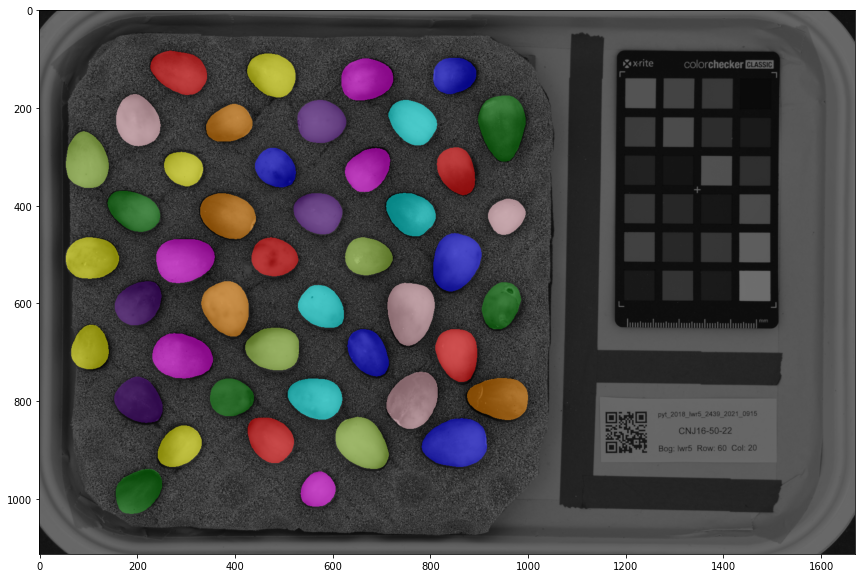

In [376]:
plt.figure(figsize = (20, 10))
plt.imshow(combined_image)
plt.show()

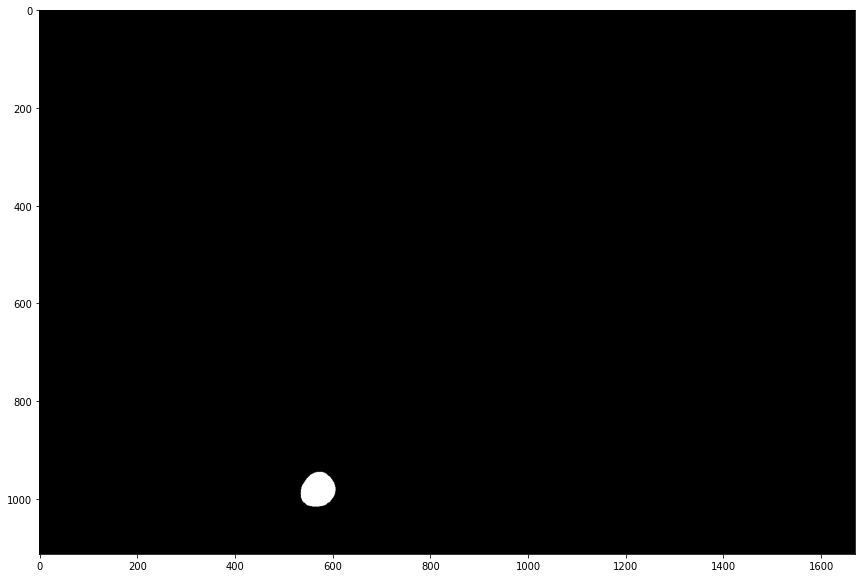

In [279]:
plt.figure(figsize = (20, 10))
plt.imshow(berry_mask_i, cmap = "gray")
plt.show()

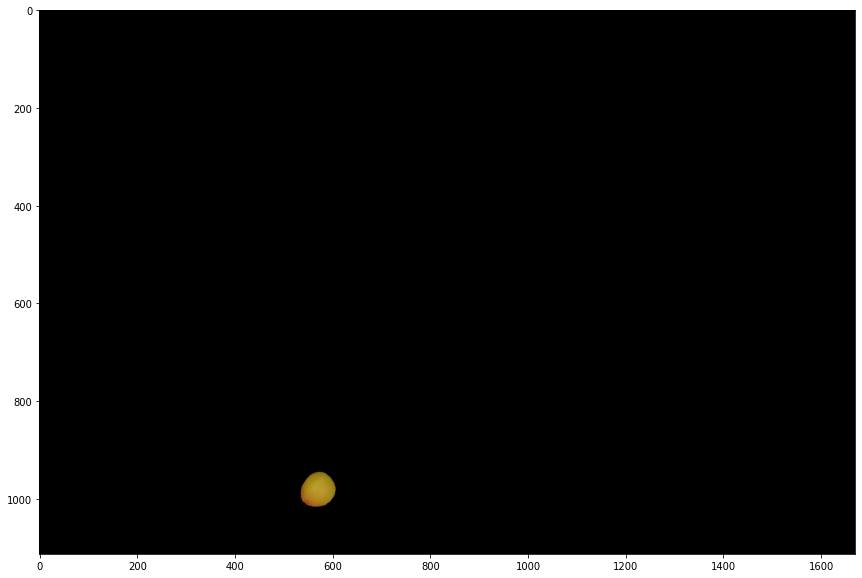

In [280]:
plt.figure(figsize = (20, 10))
plt.imshow(berry_rgb_i)
plt.show()

In [289]:
np.nan


nan

In [14]:





sort_idx = np.argsort([(int(filename.split(proceeding)[1].split(following)[0])) for filename in filenames])
# sort_idx = np.argsort([(int(filename.split(following)[0])) for filename in filenames])

for i in sort_idx:
    #makes new directory called "(directory name here) + name in red" that your new images go into
    new_dir_name = seg_output_directory
    if not os.path.exists(new_dir_name):
      os.makedirs(new_dir_name)
    
    for mat in materials:
      new_dir_name_mat= new_dir_name + "/" + mat.name
      if not os.path.exists(new_dir_name_mat):
        os.makedirs(new_dir_name_mat)
    filename = filenames[i]
    
    image = Image.open(dir_name +'/'+ filenames[i])
    image1=(image)
    image1=np.array(image1)
    image1=rgb2grey(image1)
    image1 = rescale(image1, scale, anti_aliasing=True)
    
    w, h = image.size
    # print(image.size)
    #!!!!!!!!!!!!!!!!!!!!Make sure scale matches!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    scale=scale
    newW, newH = int(scale * w), int(scale * h)
    image=image.resize((newW, newH))
    image1 = image1[0:newH, 0:newW] # Add this to resize image1
    image=np.array(image, dtype=float)
    new_im=np.zeros((3, newH, newW))
    new_im[0,:,:]=image[:,:,0]
    new_im[1,:,:]=image[:,:,1]
    new_im[2,:,:]=image[:,:,2]
    image=new_im
    

    image=torch.from_numpy(image)

#!!!!!!!!!!!!!!!!!!!!!!!!!!Make sure normalization goes match above!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    image=T.Normalize(mean=mean, std=std)(image)
 
    image.unsqueeze_(0)
    image = image.to(device=device, dtype=torch.float32)


    with torch.no_grad():
      mask=model(image)['out']
      mask=nn.Sigmoid()(mask)
      # mask=mask.cpu().detach().numpy()
#!!!!!!!!!!!!!!!!!Make sure there are the same number of mask outputs as you trained on!!!!!!!!!!!!!!!!!!!!!
    
    # combined_image = image_rescaled = rescale(image, scale, anti_aliasing=True)
    for i, mat in enumerate(materials):
      mat_mask = mask.cpu().detach().numpy()[0,i,:,:]
      mat_mask[mat_mask >= mat.confidence_threshold] = mat.output_val
      mat_mask[mat_mask < mat.confidence_threshold] = 0


      distance = ndi.distance_transform_edt(mat_mask)

      local_max_coords = feature.peak_local_max(distance, footprint=np.ones((50, 50)))
      local_max_mask = np.zeros(distance.shape, dtype=bool)
      local_max_mask[tuple(local_max_coords.T)] = True
      markers = measure.label(local_max_mask)
      
      seg1 = segmentation.watershed(-distance, markers, mask=mat_mask)
    
      # sobel = scipy.ndimage.sobel(mat_mask)

      # sobel= ndi.binary_fill_holes(sobel)
      # selem=disk(10)
      # sobel=binary_erosion(sobel, selem=selem)
      
      # # # io.imshow(sobel)
      # markers = np.zeros_like(sobel)
      # foreground, background = 1, 2
      # markers[sobel <= 0] = background
      # markers[sobel >=1] = foreground
      # io.imshow(sobel)

      # ws = watershed(sobel, markers,mask=mat_mask, compactness=0.1)
      
      # seg1 = measure.label(ws == foreground)
      

      combined_image = np.add(image1, mat_mask, casting="unsafe")
      # img3=label2rgb(combined_image, image1, alpha=0.2) 
      img3=label2rgb(seg1, image1, alpha=0.5, bg_label=0)  
      io.imsave(new_dir_name+'/' + mat.name + '/'+filename.split(following)[0]+'_' + mat.name + "_mask.png", mat_mask)
      

    io.imsave(new_dir_name+'/'+filename.split(following)[0]+'.png', img3)    
    #io.imsave(new_dir_name+'/'+filename.split(following)[0]+'.png', seg1)    

    # name = file_name.append([filename])
  

10 images found.


NameError: ignored

In [ ]:
#makes new directory called "(directory name here) + name in red" that your new images go into
new_dir_name = seg_output_directory
if not os.path.exists(new_dir_name):
  os.makedirs(new_dir_name)

for mat in materials:
  new_dir_name_mat= new_dir_name + "/" + mat.name
  if not os.path.exists(new_dir_name_mat):
    os.makedirs(new_dir_name_mat)
filename = filenames[i]

image = Image.open(dir_name +'/'+ filenames[i])
image1=(image)
image1=np.array(image1)
image1=rgb2grey(image1)
image1 = rescale(image1, scale, anti_aliasing=True)

w, h = image.size
# print(image.size)
#!!!!!!!!!!!!!!!!!!!!Make sure scale matches!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
scale=scale
newW, newH = int(scale * w), int(scale * h)
image=image.resize((newW, newH))
image1 = image1[0:newH, 0:newW] # Add this to resize image1
image=np.array(image, dtype=float)
new_im=np.zeros((3, newH, newW))
new_im[0,:,:]=image[:,:,0]
new_im[1,:,:]=image[:,:,1]
new_im[2,:,:]=image[:,:,2]
image=new_im


image=torch.from_numpy(image)

#!!!!!!!!!!!!!!!!!!!!!!!!!!Make sure normalization goes match above!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
image=T.Normalize(mean=mean, std=std)(image)

image.unsqueeze_(0)
image = image.to(device=device, dtype=torch.float32)


with torch.no_grad():
  mask=model(image)['out']
  mask=nn.Sigmoid()(mask)
  # mask=mask.cpu().detach().numpy()



In [ ]:

#!!!!!!!!!!!!!!!!!Make sure there are the same number of mask outputs as you trained on!!!!!!!!!!!!!!!!!!!!!

# Iterate over materials to print
for mat_name in materials_toprint:
  j = [j for j, x in enumerate(materials) if x.name == mat_name][0]
  mat = materials[j]

  mat_mask = mask.cpu().detach().numpy()[0,j,:,:]
  mat_mask[mat_mask >= mat.confidence_threshold] = 255
  mat_mask[mat_mask < mat.confidence_threshold] = 0
  # Invert the mask
  mat_mask = np.invert(np.asarray(mat_mask).astype("uint8"))

  distance = ndi.distance_transform_edt(mat_mask)

  local_max_coords = feature.peak_local_max(distance, footprint=np.ones((25, 25)))
  local_max_mask = np.zeros(distance.shape, dtype=bool)
  local_max_mask[tuple(local_max_coords.T)] = True
  markers = measure.label(local_max_mask)
  
  seg1 = segmentation.watershed(-distance, markers, mask=mat_mask)

  # sobel = scipy.ndimage.sobel(mat_mask)

  # sobel= ndi.binary_fill_holes(sobel)
  # selem=disk(10)
  # sobel=binary_erosion(sobel, selem=selem)
  
  # # # io.imshow(sobel)
  # markers = np.zeros_like(sobel)
  # foreground, background = 1, 2
  # markers[sobel <= 0] = background
  # markers[sobel >=1] = foreground
  # io.imshow(sobel)

  # ws = watershed(sobel, markers,mask=mat_mask, compactness=0.1)
  
  # seg1 = measure.label(ws == foreground)
  

  combined_image = np.add(image1, mat_mask, casting="unsafe")
  # img3=label2rgb(combined_image, image1, alpha=0.2) 
  img3=label2rgb(seg1, image1, alpha=0.5, bg_label=0)  
  io.imsave(new_dir_name+'/' + mat.name + '/'+filename.split(following)[0]+'_' + mat.name + "_mask.png", mat_mask)
  

io.imsave(new_dir_name+'/'+filename.split(following)[0]+'.png', img3)    
#io.imsave(new_dir_name+'/'+filename.split(following)[0]+'.png', seg1)    

name = file_name.append([filename])

## Test object detection, counting

This section will test code to read in masks, perform watershed segmentation, and output measurements of the features


In [ ]:
# Packages to load
from skimage.color import rgb2gray, label2rgb
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io,exposure, feature, filters, io, measure, morphology, restoration, segmentation, util, data
from skimage.measure import label, regionprops_table, regionprops
from scipy import ndimage as ndi
import imageio
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd

# Material to segment
material = "berry"
# Distance to use for segmentation
distance = 10
# Properties to extract from regionprops
region_properties = ["area", "axis_major_length", "axis_minor_length", "eccentricity"]

# List masks for that material
mat_mask_files = [x for x in os.listdir(seg_output_directory + "/" + material) if "PNG" in x.upper()]



# Iterate over the masks
# for file in mat_mask_files:
    
    # Read in the mask file

# file = "DSC_0396image12_berry_mask.png"
file = mat_mask_files[0]


In [ ]:
mat_mask = imageio.imread(seg_output_directory + "/" + material + "/" + file)
h, w = mat_mask.shape

# This is from https://github.com/danforthcenter/plantcv/blob/master/plantcv/plantcv/watershed.py
# 
dist_transform = cv.distanceTransformWithLabels(mat_mask, cv.DIST_L2, maskSize = 0)[0]
local_max = feature.peak_local_max(dist_transform, indices = False, min_distance = distance, labels = mat_mask)

markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]
dist_transform1 = -dist_transform
seg1 = segmentation.watershed(dist_transform1, markers, mask = mat_mask)

###
# Estimate berry traits
###

# Label the segmentation output
label_mat = label(np.array(seg1), background = 0)

# Regionprops
region_properties1 = list(set(["label", "bbox"] + region_properties))
regions_df = regionprops_table(label_image = label_mat, properties = region_properties1)







<ipython-input-74-1210eb2153aa>:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


In [ ]:
pd.DataFrame(regions_df)

# OTHER CODE THAT MAY BE DELETED

# Load functions

Do not skip this.

In [ ]:

#############################
#### Function  loading   ####
#############################


# This is the directory where models and their output will be saved
models_directory = proj_dir + "/model_output/"
# Directory for the model group (this will store the CSV output and the normalization data)
model_group_directory = models_directory + "/" + model_group
# Directory for the model group / outputs
output_directory = model_group_directory + "/models/"
# Directory for outputing segmented images from the testing set
seg_output_directory = model_group_directory + "/segmented_images/"
# Name of the CSV file to create
csv_directory =  model_group_directory + model_group.replace("/", "") + ".csv"

# Number of materials
num_materials = len(materials)


# pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html    


# #**Parameter Loading**

#Code Box 
import os
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
import random
#import scipy.ndimage as ndi
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy.ndimage import morphology
from torch.utils.data import DataLoader, random_split


# Create a list of directories to check and create
for dirpath in [models_directory, model_group_directory, output_directory, seg_output_directory]:
    # Check if exists
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
    
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=scale, transform=False):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.transform=transform
        self.t_list=A.Compose([A.HorizontalFlip(p=0.4),A.VerticalFlip(p=0.4), A.Rotate(limit=(-50, 50), p=0.4),])
        self.means=[0]
        self.stds=[1]

        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
 
        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')
 
    def __len__(self):
        return len(self.ids)
 
 
    @classmethod
    def mask_preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
 
        img_nd = np.array(pil_img)
 
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
 
       
        return img_nd
    
 
        
    def img_preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))
 
        img_nd = np.array(pil_img)
 
        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)
 
       
 
        return img_nd
 
    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + '*')
        img_file = glob(self.imgs_dir + idx + '*')
 
        assert len(mask_file) == 1,             f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1,             f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])
 
  
        
 
        
        #Reshapes from 1 channel to 3 channels in grayscale
        img = self.img_preprocess(img, self.scale)
        mask = self.mask_preprocess(mask, self.scale)
        # new_image=np.zeros((img.shape[0],img.shape[1],3))
        # new_image[:,:,0]=img[:,:,0]
        # new_image[:,:,1]=img[:,:,0]
        # new_image[:,:,2]=img[:,:,0]
        
 
 
 
        img=img
 
        new_mask = np.zeros((num_materials,img.shape[0],img.shape[1]))
        # print(mask.shape)       
        for i, mat in enumerate(materials):
          # plt.imshow(mask[:,:,0])
          # plt.show()
          indices = np.all(mask == mat.input_rgb_vals, axis=-1)
          new_mask[i,:,:][indices] = 1
 
        mask = new_mask
  
        # plt.imshow(mask[1,:,:])
        # i=6
        # for i in range(len(mask)):
        #   plt.imshow(mask[i,:,:])
        #   plt.show()
        
        if img.max() > 1:
            img = img / 255
 
       
 
        
        if self.transform:
            augmented=self.t_list(image=img, masks=mask)
            img=augmented["image"]
            mask=augmented["masks"]
            
 
        
 
        img = img.transpose((2, 0, 1))
        
        mask=np.array(mask)
        
        
 
        
 
        img=torch.from_numpy(img)
        mask=torch.from_numpy(mask)
        
        img=transforms.Normalize(mean=self.means, std=self.stds)(img)
        return img, mask





KeyboardInterrupt: 

# Parameter loading

This block can be skipped if you are only interested in model validation

In [ ]:


#############################
#### Parameter  loading   ####
#############################
 
        
dataset = BasicDataset(training_image_directory, training_mask_directory, scale=scale, transform=False)
 
#!!!!!!!!!!!!!!!!!!!!!!!!!!Set batch size here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# train, val=trainval_split(dataset, val_fraction=0.5)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)#, collate_fn=pad_collate)
#val_loader = DataLoader(val, batch_size=3, shuffle=False, num_workers=0, pin_memory=True)#, collate_fn=pad_collate)
nimages = 0
mean = 0.
std = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)
 
# Final step
mean /= nimages
std /= nimages
 
print(mean)
print(std)

dataset.means=mean
dataset.stds=std 

nimages = 0
newmean = 0.
newstd = 0.
for batch, _ in train_loader:
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    newmean += batch.mean(2).sum(0) 
    newstd += batch.std(2).sum(0)
 
# Final step
newmean /= nimages
newstd /= nimages
 
print(newmean)
print(newstd)


## Save these normalization values for the production pipeline ##

# Open a file
param_filename = model_group_directory + model_group.replace("/", "") + "_normalization_param.txt"
handle = open(param_filename, "w")

# Write all the parameters to this file
handle.write("normalization_mean" + "\t" + str(newmean) + "\n")
handle.write("normalization_std" + "\t" + str(newstd) + "\n")

# Close the file
handle.close()
